# 15-minute Accessibility Index

$$A_i =  \sum_{j} P_j f(t_{ij})$$

where $ A_i$ is the cumulative accessibility of origin hexagon $i$, $ P_j$ is the number of opportunities (amenities) in the destination hexagon $j$, and $f(t_{ij}) $ is the impedance function of travel time.

The Negative Exponential (NEXP)：

$$f(t_{ij}) = exp(-\beta t_{ij}) $$

where $t_{ij}$ is travel time (minutes) between Origin Hexagon $i$ and Destination $j$, and $\beta$ is the impedance parameter.


## 0. Load the Libraries

In [ ]:
import math
import glob
import pandas as pd
import json
import os
import geopandas as gpd
from shapely.geometry import shape
from datetime import datetime
import mapclassify as mc
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Polygon
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cor
import cartopy.io.shapereader as sr
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import shapefile

In [2]:
import matplotlib as mpl

# Times New Roman
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']

In [4]:
def add_north(ax, labelsize=12, loc_x=0.95, loc_y=0.95, width=0.04, height=0.07, pad=0.1):
    """
    Draw a compass arrow and add the 'N' text annotation
    :param ax: The coordinate area to be drawn. Axes instance plt.gca() can be obtained
    :param labelsize: The size of the 'N' text
    :param loc_x: The horizontal ratio of the lower part of the text to the entire ax
    :param loc_y: The vertical ratio of the lower part of the text to the entire ax
    :param width: The width of the compass in ax
    :param height: The height of the compass in ax
    :param pad: The gap between the text symbol and the ax ratio
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    

    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    

    triangle = mpatches.Polygon([left, top, right, center], closed=True, facecolor='white', edgecolor='black')
    

    ax.add_patch(triangle)
    

    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')

In [5]:
# the origin accessibilty
# load the data 
# flow_sum
# POI data (the sum/ and sub total)
# Travel Time

## 1.Load the dataset 
### 1.1 Flows from Level 9 to Level 8 

In [6]:
# flow_sum data
output_file_csv = f"Data/march.csv"
flows = pd.read_csv(output_file_csv)

In [7]:
lb_gdf = gpd.read_file("Data/ESRI/London_Borough_Excluding_MHW.shp")

In [8]:
# level 9 data with level 8 code
file_path = 'level9_data.geojson'
hex_8 = gpd.read_file(file_path)
# level 8 geodataframe
file_path = 'level8_hexagons.geojson'
hex_8geo = gpd.read_file(file_path)

In [9]:
# Create the index_h3 and hex_8 columns in the hex_8 dataset as dictionaries for fast lookup
h3_to_hex8_mapping = dict(zip(hex_8['index_h3'], hex_8['hex_8']))

# Define a function to get the corresponding Level 8 Hexagon code based on the Level 9 H3 code
def get_hex8_from_h3(level_9_h3):
    return h3_to_hex8_mapping.get(level_9_h3, None)

# Added Origin Level 8 Hexagon column
flows['Origin_Hex8'] = flows['ORIGIN_CODE'].apply(get_hex8_from_h3)

# Add Destination Level 8 Hexagon column
flows['Destination_Hex8'] = flows['DESTINATION_CODE'].apply(get_hex8_from_h3)

# Print the first few rows of the updated OD Trip dataset to see the results
flows.head()

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_sum,Origin_Hex8,Destination_Hex8
0,89194ac0003ffff,89194ac002fffff,3.0,88194ac001fffff,88194ac003fffff
1,89194ac0003ffff,89194ac015bffff,3.0,88194ac001fffff,88194ac015fffff
2,89194ac0003ffff,89194ac0167ffff,1.0,88194ac001fffff,88194ac017fffff
3,89194ac0003ffff,89194ac0c43ffff,3.0,88194ac001fffff,None
4,89194ac0003ffff,89194ac0c47ffff,2.0,88194ac001fffff,None


In [10]:
# Drop the hexagons outside Greater London
flows =flows.dropna(subset=['Origin_Hex8', 'Destination_Hex8'])

In [11]:
# Drop duplicate columns
flows = flows.drop(columns=['DESTINATION_CODE','ORIGIN_CODE'])

In [13]:
# Summarise the number of users according to the same OD paris
flows_hex8 = flows.groupby(['Origin_Hex8', 'Destination_Hex8'])['TRANSIENTS_sum'].sum().reset_index()

In [14]:
# check the result
flows_hex8

,Origin_Hex8,Destination_Hex8,TRANSIENTS_sum
0,88194ac001fffff,88194ac001fffff,1916.0
1,88194ac001fffff,88194ac003fffff,408.0
2,88194ac001fffff,88194ac005fffff,207.0
3,88194ac001fffff,88194ac007fffff,961.0
4,88194ac001fffff,88194ac009fffff,1058.0
...,...,...,...
2679275,88195db6bbfffff,88195db6b3fffff,708.0
2679276,88195db6bbfffff,88195db6b5fffff,219.0
2679277,88195db6bbfffff,88195db6b7fffff,42.0
2679278,88195db6bbfffff,88195db6b9fffff,99.0


### 1.2  POI data (the sum/ and sub total）with des hexagons

In [15]:
# summerised the POI number on each hexagon
poi_hex8 = gpd.read_file("Data/poi_hex8.geojson")

In [16]:
poi_hex8.head(3)

,hex_8,Culture,Education,Entertainment,GP services,Pharmacies,Sport,Total,geometry
0,88195da6d7fffff,1.0,3.0,0.0,1.0,2.0,3.0,10.0,"POLYGON ((533028.494 187118.372, 532566.674 18..."
1,88195d3643fffff,0.0,0.0,0.0,1.0,0.0,0.0,1.0,"POLYGON ((509217.896 178241.664, 508754.461 17..."
2,88194e6c17fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((552370.882 174580.849, 551909.995 17..."


### 1.3 Load and merge travel time

In [17]:
output_file_csv = f"new_travel_time.csv"
travel_time = pd.read_csv(output_file_csv)


In [18]:
# new travel time:columns after processing trips within the same hexagons and "NAN" value
# check the status
travel_time

,Unnamed: 0,Origin_Hex8,Destination_Hex8,TRANSIENTS_sum,from_id,to_id,travel_time,new_travel_time,class
0,0,88194ac001fffff,88194ac001fffff,1916.0,88194ac001fffff,88194ac001fffff,0.0,1.0,0-15 mins
1,1,88194ac001fffff,88194ac003fffff,408.0,88194ac001fffff,88194ac003fffff,9.0,9.0,0-15 mins
2,2,88194ac001fffff,88194ac005fffff,207.0,88194ac001fffff,88194ac005fffff,15.0,15.0,0-15 mins
3,3,88194ac001fffff,88194ac007fffff,961.0,88194ac001fffff,88194ac007fffff,8.0,8.0,0-15 mins
4,4,88194ac001fffff,88194ac009fffff,1058.0,88194ac001fffff,88194ac009fffff,9.0,9.0,0-15 mins
...,...,...,...,...,...,...,...,...,...
2679275,2679275,88195db6bbfffff,88195db6b3fffff,708.0,88195db6bbfffff,88195db6b3fffff,9.0,9.0,0-15 mins
2679276,2679276,88195db6bbfffff,88195db6b5fffff,219.0,88195db6bbfffff,88195db6b5fffff,17.0,17.0,16-30 mins
2679277,2679277,88195db6bbfffff,88195db6b7fffff,42.0,88195db6bbfffff,88195db6b7fffff,13.0,13.0,0-15 mins
2679278,2679278,88195db6bbfffff,88195db6b9fffff,99.0,88195db6bbfffff,88195db6b9fffff,11.0,11.0,0-15 mins


In [19]:
# merged the travel time and poi_hex8 based on the destination hexagons
access = pd.merge(travel_time, poi_hex8, left_on='Destination_Hex8', right_on='hex_8', how='left')

In [20]:
access

,Unnamed: 0,Origin_Hex8,Destination_Hex8,TRANSIENTS_sum,from_id,to_id,travel_time,new_travel_time,class,hex_8,Culture,Education,Entertainment,GP services,Pharmacies,Sport,Total,geometry
0,0,88194ac001fffff,88194ac001fffff,1916.0,88194ac001fffff,88194ac001fffff,0.0,1.0,0-15 mins,88194ac001fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((530516.565 160553.007, 530054.079 16..."
1,1,88194ac001fffff,88194ac003fffff,408.0,88194ac001fffff,88194ac003fffff,9.0,9.0,0-15 mins,88194ac003fffff,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((530834.462 159697.152, 530371.979 15..."
2,2,88194ac001fffff,88194ac005fffff,207.0,88194ac001fffff,88194ac005fffff,15.0,15.0,0-15 mins,88194ac005fffff,0.0,2.0,0.0,1.0,0.0,0.0,3.0,"POLYGON ((529663.876 160762.807, 529201.343 16..."
3,3,88194ac001fffff,88194ac007fffff,961.0,88194ac001fffff,88194ac007fffff,8.0,8.0,0-15 mins,88194ac007fffff,1.0,0.0,0.0,0.0,2.0,1.0,4.0,"POLYGON ((529981.774 159906.920, 529519.243 15..."
4,4,88194ac001fffff,88194ac009fffff,1058.0,88194ac001fffff,88194ac009fffff,9.0,9.0,0-15 mins,88194ac009fffff,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((531051.292 161199.022, 530588.851 16..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679275,2679275,88195db6bbfffff,88195db6b3fffff,708.0,88195db6bbfffff,88195db6b3fffff,9.0,9.0,0-15 mins,88195db6b3fffff,1.0,1.0,0.0,2.0,1.0,0.0,5.0,"POLYGON ((536141.740 199527.826, 535680.353 19..."
2679276,2679276,88195db6bbfffff,88195db6b5fffff,219.0,88195db6bbfffff,88195db6b5fffff,17.0,17.0,16-30 mins,88195db6b5fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((534973.430 200592.378, 534511.993 20..."
2679277,2679277,88195db6bbfffff,88195db6b7fffff,42.0,88195db6bbfffff,88195db6b7fffff,13.0,13.0,0-15 mins,88195db6b7fffff,1.0,2.0,0.0,0.0,0.0,0.0,3.0,"POLYGON ((535290.906 199738.800, 534829.471 19..."
2679278,2679278,88195db6bbfffff,88195db6b9fffff,99.0,88195db6bbfffff,88195db6b9fffff,11.0,11.0,0-15 mins,88195db6b9fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((536357.557 201023.872, 535896.212 20..."


In [21]:
# check the data status 
# cloumn: new_travel_time
nan_counts = access.isna().sum()
print(nan_counts)

Unnamed: 0               0
Origin_Hex8              0
Destination_Hex8         0
TRANSIENTS_sum           0
from_id                  0
to_id                    0
travel_time         833852
new_travel_time          0
class                    0
hex_8                    0
Culture                  0
Education                0
Entertainment            0
GP services              0
Pharmacies               0
Sport                    0
Total                    0
geometry                 0
dtype: int64


In [22]:
# Tips: Some destinations do not have POI data
access_total = access [access['Total']== 0]
print(len(access_total))
# check the time distribution
access_total['class'].value_counts()

555728


class
106+ mins      257914
46-60 mins      55379
61-75 mins      54422
76-90 mins      50481
31-45 mins      47939
91-105 mins     46823
16-30 mins      32407
0-15 mins       10363
Name: count, dtype: int64

## 2. 15-minute Accessiblity Index
### 2.1 Calculate 15-minute Accessiblity Index

In [66]:
beta = 0.1535

# Tips change the amenities type in here
def calculate_accessibility(df, beta):
    df['A_i'] = df['Total'] * np.exp(-beta * df['new_travel_time'])
    access = df.groupby('Origin_Hex8')['A_i'].sum().reset_index()
    access.columns = ['Origin_Hex8', 'A_i']
    return access

# Calculate accessibility for each origin
accessibility = calculate_accessibility(access, beta)

### 2.2 Min-Max Scaling
$$
A_{i_{normalized}} = \frac{A_i - A_{i_{min}}}{A_{i_{max}} - A_{i_{min}}}
$$

where $A_{i_{normalized}}$ is the normalised accessibility result for origin $i$, $A_{i_{min}}$ is the minimum value of $A_i$ among all origins, and $A_{i_{max}}$ is the maximum value of $A_i$ among all origins. \\

In [67]:
# Min-Max Scaling
accessibility['accessibility_min_max'] = (accessibility['A_i'] - accessibility['A_i'].min()) / (accessibility['A_i'].max() - accessibility['A_i'].min())


In [68]:
accessibility.describe()

,A_i,accessibility_min_max
count,2496.000000,2496.000000
mean,24.064374,0.263035
std,18.435407,0.201508
min,0.000000,0.000000
25%,9.576487,0.104676
50%,21.360610,0.233482
75%,34.597376,0.378166
max,91.487238,1.000000


### 2.3 Visualise the Results

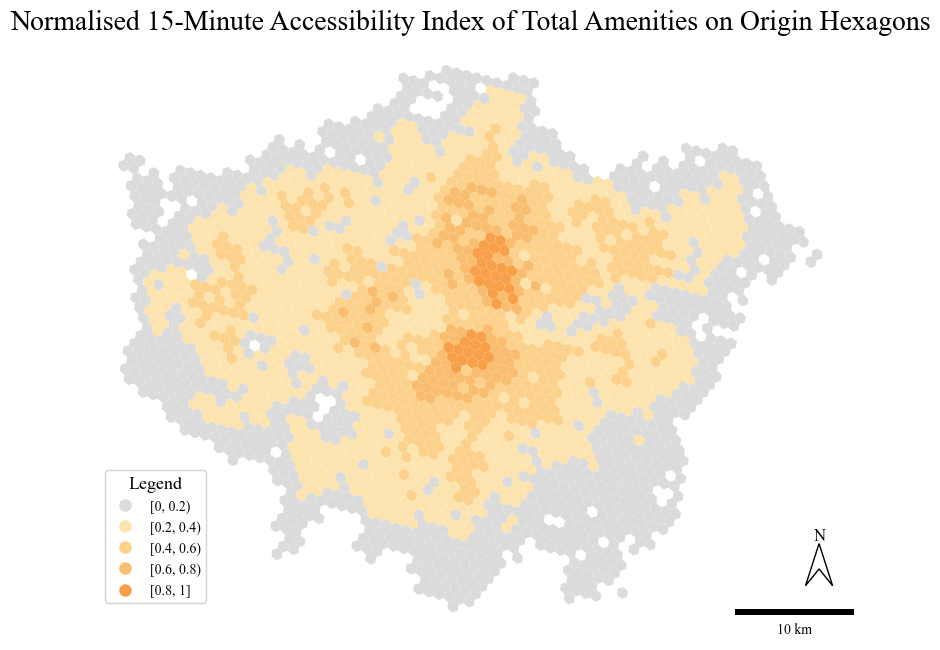

In [65]:
hex_8_access_N = pd.merge(hex_8geo, accessibility, left_on='hex_8', right_on='Origin_Hex8', how='left')
hex_8_access_N = gpd.GeoDataFrame(hex_8_access_N, geometry='geometry')
hex_8_access_N =hex_8_access_N.to_crs(epsg=27700)
# Define the bins for classification
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1]']

# Classify the 'accessibility_min_max' values into the specified bins
hex_8_access_N['accessibility_class'] = pd.cut(hex_8_access_N['accessibility_min_max'], bins=bins, labels=labels, include_lowest=True)

# Define a custom color map for the bins
colors = ['#DBDBDB', '#FDE4AF', '#FBD18B', '#F9BD6F', '#F7A049']
cmap = mcolors.ListedColormap(colors)

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Set the image background to be transparent
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plot the GeoDataFrame with color mapping based on the classified data
hex_8_access_N.plot(column='accessibility_class', 
                    ax=ax, 
                    legend=False,
                    cmap=cmap )  # Simplified legend settings
#lb_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.3, aspect='equal',alpha=0.5)
# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(labels))]
labels = labels
ax.legend(handles=handles, 
          labels=labels, 
          title="Legend",  # Add a title to the legend
          loc='lower left',  # Position the legend in the lower left corner
          bbox_to_anchor=(0.02, 0.05),  # Adjust the position within the figure
          title_fontsize='13',  # Set title font size
          fontsize='10')  # Set font size of the labels


# Add scale bar
scalebar = ScaleBar(1, units='m', scale_loc='bottom', location='lower right')
ax.add_artist(scalebar)

# Add compass/north arrow (assuming you have a function add_north)
add_north(ax, labelsize=12, loc_x=0.95, loc_y=0.23, width=0.035, height=0.07, pad=0.14)

# Add title and labels
plt.title('Normalised 15-Minute Accessibility Index of Total Amenities on Origin Hexagons', fontsize= 20)

# Show plot
ax.axis('off')
plt.show()